# DataSet Object
(*Objective: (Re-)introduce machine learning datasets and basic concepts of object oriented design, how to use custom libraries in Collab. Time: 15 mins*) 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


## Basics of machine learning datasets
A machine learning dataset is usually a collection of labelled samples, each one holding numerical values for features, that forms a representation vector. The collection is split to **training** and **testing** subsets, the first used during training and the second remains unknown in order to evaluate the model. If we have a large testing subset we split the collection of training samples into training and **validation** subsets, usually 90%/10%. Thus we use the smaller validation set to inspect the convergence during training.

## Object oriented design
We will treat the dataset as an object that holds composite objects for subsets, wherein the samples and labels reside.
```
------------------------------
|        :DataSet            |
|----------------------------|
|  + Training   :DataSubSet  |
|  + Validation :DataSubSet  | 
|  + Testing    :DataSubSet  |
------------------------------
```
### The :DataSet and :DataSubSet class relation
The `:DataSetCifar10` class is responsible of loading the data from the filesystem and placing them into a composite object of the `:DataSubSet` class that corresponds to training/validation/testing subset. The samples will be provided o the learning process by these instances.

### Implementation Notes
*   The constructor of `:DataSetCifar10` expects a class reference that will be used to create the subset objects. In [unit tests](http://softwaretestingfundamentals.com/unit-testing/) below we provide the local declaration of `:DataSubSet`.
*   The `:DataSetCifar10.Load()` method ensures that the files of the dataset are downloaded and placed in the path given in the `DataSetFolder` property. The files are loaded into numpy arrays and the 5 shards are concatenated in the training subset.
*   The channel order of each image is transposed to R,G,B and the sample is kept in a 3D tensor with 32bit floating point values. 

[Training] Samples (Count,Features):(50000, 32, 32, 3)  Labels (Count):(50000,)
[Testing ] Samples (Count,Features):(10000, 32, 32, 3)  Labels (Count):(10000,)

Sample #00007 Class:horse


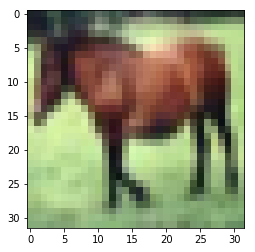

Sample #00008 Class:ship


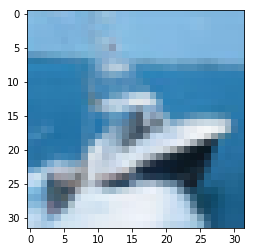

Sample #00001 Class:truck


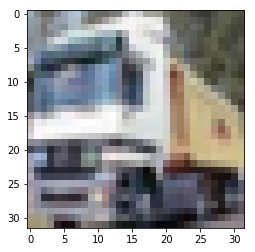

In [0]:
import os
import shutil
import sys
import zipfile
import tarfile
import pickle
from urllib.request import urlretrieve
import numpy as np

ORIGINAL_DATASET_FOLDER = "/content/gdrive/My Drive/Colab Notebooks/OOT2019/data/cifar10"


# =======================================================================================================================
class DataSubSet(object):
    # --------------------------------------------------------------------------------------------------------
    def __init__(self):
        self.Samples      = None
        self.Labels       = None
        self.UIDs         = None
        self.SampleCount  = None
    # --------------------------------------------------------------------------------------------------------
    def AppendShard(self, p_nSamples, p_nLabels):
        if self.Samples is None:
            self.Samples = p_nSamples
            self.SampleCount = 0
        else:
            self.Samples = np.concatenate((self.Samples, p_nSamples), axis=0)
        
         
        
        if self.Labels is None:
            self.Labels = p_nLabels
        else:
            self.Labels = np.concatenate((self.Labels, p_nLabels), axis=0)
            
        nNextUIDs = np.arange(self.SampleCount, self.SampleCount + p_nSamples.shape[0],  dtype=np.int32)
            
        if self.UIDs is None:
          self.UIDs = nNextUIDs
        else:    
          self.UIDs = np.concatenate((self.UIDs, nNextUIDs), axis=0)
          
        self.SampleCount += p_nSamples.shape[0]
    # --------------------------------------------------------------------------------------------------------
    def GetSamples(self, p_nIndexes):
      
      nSamples = self.Samples[p_nIndexes]
      nLabels  = self.Labels[p_nIndexes]
      nUIDs    = self.UIDs[p_nIndexes]
      
      return nSamples, nLabels, nUIDs
    # --------------------------------------------------------------------------------------------------------
# =======================================================================================================================

  

# =======================================================================================================================
class DataSetCifar10(object):
    DOWNLOAD_URL = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    
    # --------------------------------------------------------------------------------------------------------
    def __init__(self, p_cDataSubSet=None, p_sDataFolder=ORIGINAL_DATASET_FOLDER):
        self.DataSubSetClass = p_cDataSubSet
        
        self.Training   = None
        self.Validation = None
        self.Testing    = None
        
        self.Samples      = None
        self.Labels       = None
        self.SampleCount  = None
        
        self.TempFolder = "/tmp"
        self.DataFolder = p_sDataFolder
        
        self.BatchesFile                = os.path.join(self.DataFolder, 'batches.meta')
        self.TrainingShardFileTemplate  = os.path.join(self.DataFolder, 'data_batch_%d')
        self.TestFileName               = os.path.join(self.DataFolder, 'test_batch')
        
        self.ClassNames = {  0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer" 
                               , 5:"dog", 6: "frog", 7:"horse", 8:"ship", 9:"truck"}
    # --------------------------------------------------------------------------------------------------------            
    def _downloadProgressCallBack(self, count, block_size, total_size):
        pct_complete = float(count * block_size) / total_size
        msg = "\r- Download progress: {0:.1%}".format(pct_complete)
        sys.stdout.write(msg)
        sys.stdout.flush()        
    # --------------------------------------------------------------------------------------------------------
    def __ensureDataSetIsOnDisk(self):
        sSuffix = DataSetCifar10.DOWNLOAD_URL.split('/')[-1]
        sArchiveFileName = os.path.join(self.TempFolder, sSuffix)
        
        if not os.path.isfile(sArchiveFileName):
            sFilePath, _ = urlretrieve(url=DataSetCifar10.DOWNLOAD_URL, filename=sArchiveFileName, reporthook=self._downloadProgressCallBack)
            print()
            print("Download finished. Extracting files.")

            
        if sArchiveFileName.endswith(".zip"):
            zipfile.ZipFile(file=sArchiveFileName, mode="r").extractall(self.TempFolder)
        elif sArchiveFileName.endswith((".tar.gz", ".tgz")):
            tarfile.open(name=sArchiveFileName, mode="r:gz").extractall(self.TempFolder)
        print("Done.")

        shutil.move(os.path.join(self.TempFolder, "./cifar-10-batches-py"), self.DataFolder)

        os.remove(sArchiveFileName)
    # --------------------------------------------------------------------------------------------------------
    def _transposeImageChannels(self, p_nX, p_nShape=(32, 32, 3), p_bIsFlattening=False):
        nResult = np.asarray(p_nX, dtype=np.float32)
        nResult = nResult.reshape([-1, p_nShape[2], p_nShape[0], p_nShape[1]])
        nResult = nResult.transpose([0, 2, 3, 1])
        
        if p_bIsFlattening:
          nResult = nResult.reshape(-1, np.prod(np.asarray(p_nShape)))
        
        return nResult     
    # --------------------------------------------------------------------------------------------------------
    def Load(self):
        if not os.path.exists(self.DataFolder):
            self.__ensureDataSetIsOnDisk()
      
        self.LoadSubset(True)
        self.LoadSubset(False)
    # --------------------------------------------------------------------------------------------------------
    def LoadSubset(self, p_bIsTrainingSubSet=True):
        if p_bIsTrainingSubSet:
            self.Training = self.DataSubSetClass()

            for i in range(5):
                with open(self.TrainingShardFileTemplate % (i+1), 'rb') as oFile:
                    oDict = pickle.load(oFile, encoding='latin1')
                    oFile.close()
                self.Training.AppendShard(self._transposeImageChannels(oDict["data"], (32,32,3)), np.array(oDict['labels'], np.uint8))
        else:
            self.Testing = self.DataSubSetClass() 
            
            with open(self.TestFileName, 'rb') as oFile:
                oDict = pickle.load(oFile, encoding='latin1')
                oFile.close()
            self.Testing.AppendShard(self._transposeImageChannels(oDict["data"], (32,32,3)), np.array(oDict['labels'], np.uint8))
    # --------------------------------------------------------------------------------------------------------
# =======================================================================================================================




# --------------------------------------------------------------------------------------------------------
def UnitTestLoading():
    oDataSet = DataSetCifar10(DataSubSet)
    oDataSet.Load()
    
    print("[Training] Samples (Count,Features):%s  Labels (Count):%s" % (oDataSet.Training.Samples.shape, oDataSet.Training.Labels.shape))
    print("[Testing ] Samples (Count,Features):%s  Labels (Count):%s" % (oDataSet.Testing.Samples.shape , oDataSet.Testing.Labels.shape))
    print()
        
    import matplotlib.pyplot as plt
    
    
    nSamples, nLabels, nUIDs = oDataSet.Training.GetSamples([7,8,1])
    
    for nIndex, nUID in enumerate(nUIDs):
      print("Sample #%.5d Class:%s" % (nUID, oDataSet.ClassNames[nLabels[nIndex]]))
      nImage =  nSamples[nIndex,...].astype(np.uint8)
      plt.imshow(nImage)
      plt.show()
# --------------------------------------------------------------------------------------------------------      
      
    
if __name__ == "__main__":
    UnitTestLoading()







## Decoupling the data classes

We can decouple the two classes, by placing `:DataSetCifar10` in an external python source code file named `cifar10.py` inside common library folder named `/lib/ootf`. This will create the namespace **ootf.cifar**

To include `lib` into the system search path, so that python can import from there, execute the following:

In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/OOT2019/lib')

# Display the system path elements
for sFolder in sys.path:
  print(sFolder)


/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
/content/gdrive/My Drive/Colab Notebooks/OOT2019/lib
/content/gdrive/My Drive/Colab Notebooks/OOT2019/lib


The `ootf.cifar:DataSubSet` class is passed to the constructor of `:DataSetCifar10`

[Training] Samples (Count,Features):(50000, 32, 32, 3)  Labels (Count):(50000,)
[Testing ] Samples (Count,Features):(10000, 32, 32, 3)  Labels (Count):(10000,)

Sample #00007 Class:horse


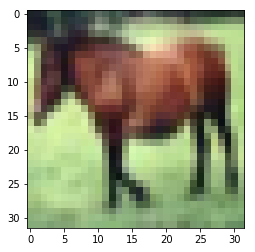

Sample #00008 Class:ship


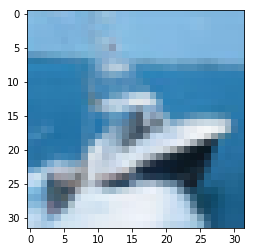

Sample #00001 Class:truck


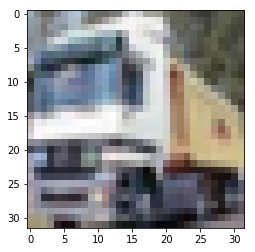

In [0]:
import numpy as np
from ootf.cifar10 import DataSetCifar10


# =======================================================================================================================
class DataSubSet(object):
    # --------------------------------------------------------------------------------------------------------
    def __init__(self):
        self.Samples      = None
        self.Labels       = None
        self.UIDs         = None
        self.SampleCount  = None
    # --------------------------------------------------------------------------------------------------------
    def AppendShard(self, p_nSamples, p_nLabels):
        if self.Samples is None:
            self.Samples = p_nSamples
            self.SampleCount = 0
        else:
            self.Samples = np.concatenate((self.Samples, p_nSamples), axis=0)
        
         
        
        if self.Labels is None:
            self.Labels = p_nLabels
        else:
            self.Labels = np.concatenate((self.Labels, p_nLabels), axis=0)
            
        nNextUIDs = np.arange(self.SampleCount, self.SampleCount + p_nSamples.shape[0],  dtype=np.int32)
            
        if self.UIDs is None:
          self.UIDs = nNextUIDs
        else:    
          self.UIDs = np.concatenate((self.UIDs, nNextUIDs), axis=0)
          
        self.SampleCount += p_nSamples.shape[0]
    # --------------------------------------------------------------------------------------------------------
    def GetSamples(self, p_nIndexes):
      
      nSamples = self.Samples[p_nIndexes]
      nLabels  = self.Labels[p_nIndexes]
      nUIDs    = self.UIDs[p_nIndexes]
      
      return nSamples, nLabels, nUIDs
    # --------------------------------------------------------------------------------------------------------
# =======================================================================================================================



# --------------------------------------------------------------------------------------------------------
def UnitTestLoading():
    oDataSet = DataSetCifar10(DataSubSet, ORIGINAL_DATASET_FOLDER)
    oDataSet.Load()
    
    print("[Training] Samples (Count,Features):%s  Labels (Count):%s" % (oDataSet.Training.Samples.shape, oDataSet.Training.Labels.shape))
    print("[Testing ] Samples (Count,Features):%s  Labels (Count):%s" % (oDataSet.Testing.Samples.shape , oDataSet.Testing.Labels.shape))
    print()
        
    import matplotlib.pyplot as plt
    
    
    nSamples, nLabels, nUIDs = oDataSet.Training.GetSamples([7,8,1])
    
    for nIndex, nUID in enumerate(nUIDs):
      print("Sample #%.5d Class:%s" % (nUID, oDataSet.ClassNames[nLabels[nIndex]]))
      nImage =  nSamples[nIndex,...].astype(np.uint8)
      plt.imshow(nImage)
      plt.show()
# --------------------------------------------------------------------------------------------------------      
      
    
if __name__ == "__main__":
    UnitTestLoading()




## An iterable subset of data

We extend the functionality of `:DataSubSet` to implement a Python iterator that can return batches of data in a very 
practical for loop. 

### Implementation Notes
*   To implement a Python iterator the `__iter__()` method should return the instance of the object and the `__next__()` method should raise a special `:StopIteration` exception to signal the end of the iteration.
*   There is an example property `:DataSubSet.BatchSize` illustrating how to implement getters/setters in Python.

[Training] Batches :7

Epoch:1
Step #001 | Range:[00000 - 08191] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
(32, 32, 3)


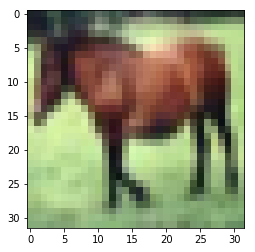

Step #002 | Range:[08192 - 16383] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #003 | Range:[16384 - 24575] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #004 | Range:[24576 - 32767] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #005 | Range:[32768 - 40959] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #006 | Range:[40960 - 49151] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #007 | Range:[49152 - 49999] Samples:(848, 32, 32, 3) Labels:(848,) UIDs:(848,)
Epoch:2
Step #008 | Range:[00000 - 08191] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
(32, 32, 3)


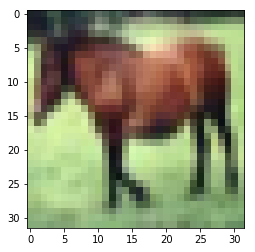

Step #009 | Range:[08192 - 16383] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #010 | Range:[16384 - 24575] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #011 | Range:[24576 - 32767] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #012 | Range:[32768 - 40959] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #013 | Range:[40960 - 49151] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #014 | Range:[49152 - 49999] Samples:(848, 32, 32, 3) Labels:(848,) UIDs:(848,)
Epoch:3
Step #015 | Range:[00000 - 08191] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
(32, 32, 3)


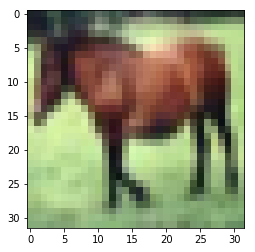

Step #016 | Range:[08192 - 16383] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #017 | Range:[16384 - 24575] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #018 | Range:[24576 - 32767] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #019 | Range:[32768 - 40959] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #020 | Range:[40960 - 49151] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #021 | Range:[49152 - 49999] Samples:(848, 32, 32, 3) Labels:(848,) UIDs:(848,)


In [0]:
import numpy as np
from ootf.cifar10 import DataSetCifar10




# =======================================================================================================================
class DataSubSet(object):
    # --------------------------------------------------------------------------------------------------------
    def __init__(self):
        self.Samples            = None
        self.Labels             = None
        self.UIDs               = None
        self.SampleCount        = None
        
        self.__batchSize        = None
        self.BatchCount         = None
        
        self.EndOfData          = True
        self.BatchIndex         = None
    # --------------------------------------------------------------------------------------------------------
    @property
    def BatchSize(self):
      return self.__batchSize
    # --------------------------------------------------------------------------------------------------------
    @BatchSize.setter
    def BatchSize(self, p_nValue):
      self.__batchSize = p_nValue
      self.BatchCount = int(self.SampleCount / self.BatchSize)
      if (self.SampleCount % self.BatchSize) != 0:
        self.BatchCount += 1
    # --------------------------------------------------------------------------------------------------------
    def AppendShard(self, p_nSamples, p_nLabels):
        if self.Samples is None:
            self.Samples = p_nSamples
            self.SampleCount = 0
        else:
            self.Samples = np.concatenate((self.Samples, p_nSamples), axis=0)
        
        if self.Labels is None:
            self.Labels = p_nLabels
        else:
            self.Labels = np.concatenate((self.Labels, p_nLabels), axis=0)
            
        nNextUIDs = np.arange(self.SampleCount, self.SampleCount + p_nSamples.shape[0],  dtype=np.int32)
            
        if self.UIDs is None:
          self.UIDs = nNextUIDs
        else:    
          self.UIDs = np.concatenate((self.UIDs, nNextUIDs), axis=0)
          
        self.SampleCount += p_nSamples.shape[0]
    # --------------------------------------------------------------------------------------------------------
    def GetSamples(self, p_nIndexes):
      
      nSamples = self.Samples[p_nIndexes]
      nLabels  = self.Labels[p_nIndexes]
      nUIDs    = self.UIDs[p_nIndexes]
      
      return nSamples, nLabels, nUIDs
    # --------------------------------------------------------------------------------------------------------
    def __iter__(self):
        assert self.__batchSize is not None, "Batch size not specified"
        
        self.BatchIndex = 0
        self.EndOfData = False      
        return self
    # --------------------------------------------------------------------------------------------------------
    def __next__(self):
        #if self.BatchIndex  < (self.BatchCount - 1):
        if self.BatchIndex  < self.BatchCount:
            nStartRange = self.BatchIndex*self.BatchSize
            nEndRange   = (self.BatchIndex + 1)*self.BatchSize

            if nEndRange >= self.SampleCount:
                nEndRange = self.SampleCount
            
            nBatchRange     = np.arange(nStartRange, nEndRange, dtype=int)
            nBatchSamples   = self.Samples[nBatchRange,...]
            nBatchLabels    = self.Labels[nBatchRange,...]
            nBatchUIDs      = self.UIDs[nBatchRange]
            
            self.BatchIndex  += 1
            self.EndOfData = (self.BatchIndex == self.BatchCount)
            
            return nBatchRange, nBatchSamples, nBatchLabels, nBatchUIDs
        else:
            raise StopIteration()        
    # --------------------------------------------------------------------------------------------------------
# =======================================================================================================================




# --------------------------------------------------------------------------------------------------------
def UnitTestIteration():
    import matplotlib.pyplot as plt
    
    oDataSet = DataSetCifar10(DataSubSet, ORIGINAL_DATASET_FOLDER)
    oDataSet.Load()
    oDataSet.Training.BatchSize = 8192
    
    print("[Training] Batches :%d" % (oDataSet.Training.BatchCount))
    print()

    
    
    nStepIndex = 1
    nEpochNumber = 1
    while nEpochNumber < 4: 
      print("Epoch:%d" % nEpochNumber)
      for nBatchRange, nBatchSamples, nBatchLabels, nBatchUIDs in oDataSet.Training:
        print("Step #%.3d | Range:[%.5d - %.5d]" % (nStepIndex, nBatchRange[0], nBatchRange[-1]), "Samples:%s Labels:%s UIDs:%s" % (nBatchSamples.shape, nBatchLabels.shape, nBatchUIDs.shape))
        # Show the horse
        if 7 in nBatchUIDs:
          nImage =  nBatchSamples[np.where(nBatchUIDs==7)][0,...].astype(np.uint8)
          print(nImage.shape)
          plt.imshow(nImage)
          plt.show()
      
        nStepIndex += 1
      nEpochNumber += 1
      
# --------------------------------------------------------------------------------------------------------      
      
    
if __name__ == "__main__":
    UnitTestIteration()


The `:DataSubSet` class is added to the **oot.base** namespace of our framework. 

Epoch:1
Step #001 | Range:[00000 - 08191] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
(32, 32, 3)


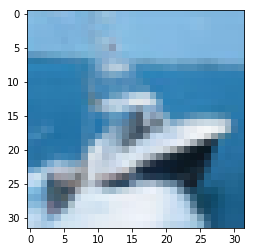

Step #002 | Range:[08192 - 16383] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #003 | Range:[16384 - 24575] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #004 | Range:[24576 - 32767] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #005 | Range:[32768 - 40959] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #006 | Range:[40960 - 49151] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #007 | Range:[49152 - 49999] Samples:(848, 32, 32, 3) Labels:(848,) UIDs:(848,)
Epoch:2
Step #008 | Range:[00000 - 08191] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
(32, 32, 3)


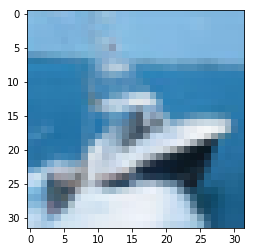

Step #009 | Range:[08192 - 16383] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #010 | Range:[16384 - 24575] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #011 | Range:[24576 - 32767] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #012 | Range:[32768 - 40959] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #013 | Range:[40960 - 49151] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #014 | Range:[49152 - 49999] Samples:(848, 32, 32, 3) Labels:(848,) UIDs:(848,)
Epoch:3
Step #015 | Range:[00000 - 08191] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
(32, 32, 3)


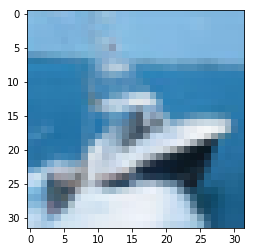

Step #016 | Range:[08192 - 16383] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #017 | Range:[16384 - 24575] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #018 | Range:[24576 - 32767] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #019 | Range:[32768 - 40959] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #020 | Range:[40960 - 49151] Samples:(8192, 32, 32, 3) Labels:(8192,) UIDs:(8192,)
Step #021 | Range:[49152 - 49999] Samples:(848, 32, 32, 3) Labels:(848,) UIDs:(848,)


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/OOT2019/lib')

import matplotlib.pyplot as plt
from ootf.base import DataSubSet
from ootf.cifar10 import DataSetCifar10


oDataSet = DataSetCifar10(DataSubSet, ORIGINAL_DATASET_FOLDER)
oDataSet.Load()
oDataSet.Training.BatchSize = 8192


nStepIndex = 1
nEpochNumber = 1
while nEpochNumber < 4: 
  print("Epoch:%d" % nEpochNumber)
  for nBatchRange, nBatchSamples, nBatchLabels, nBatchUIDs in oDataSet.Training:
    print("Step #%.3d | Range:[%.5d - %.5d]" % (nStepIndex, nBatchRange[0], nBatchRange[-1]), "Samples:%s Labels:%s UIDs:%s" % (nBatchSamples.shape, nBatchLabels.shape, nBatchUIDs.shape))
    # Show the boat
    if 8 in nBatchUIDs:
      nImage =  nBatchSamples[np.where(nBatchUIDs==8)][0,...].astype(np.uint8)
      print(nImage.shape)
      plt.imshow(nImage)
      plt.show()    
    nStepIndex += 1
  nEpochNumber += 1